# Evaluate and fit a ML model on the EC flux tower data 

Notes on model iterations:

Testing features:
All models include:

     'kNDVI_anom_RS',
     'FPAR_RS',
     'LST_RS',
     'tree_cover_RS',
     'nontree_cover_RS',
     'nonveg_cover_RS',
     'LST-Tair_RS',
     'TWI_RS',
     'NDWI_RS',
     'rain_anom_RS',
     'rain_cml3_anom_RS',
     'rain_cml6_anom_RS',
     'rain_cml12_anom_RS',
     'srad_anom_RS',
     'vpd_RS',
     'tavg_anom_RS',
     'SOC_RS',
     'C4_percent_RS'

PLUS:

- `20221122` inlcuded MI, Elevation, and VegH (where MI using pan evaporation)
- `20221123` included MI, Elevation (where MI using pan evaporation)
- `20221128` included MI (where MI using pan evaporation)
- `20221129` All of the above features removed.
- `20221130` Including MI but where MI uses AWRA Penman–Monteith PET instead of pan evap.
- `20221206` Including Penman–Monteith MI, removed Daly Uncleared, added kNDVI, update EC data with 2022 data
- `20221208` As per 20221206 but using fPAR-NDVI (Donohue) instead of MODIS fPAR
- `20221212` Remove fPAR. Update climate vars to use actual values rather than anomalies (srad, tavg, rain) (keep rainfall anomalies)
- `20230109` Remove monthly rain_anom (already contained in 3-month cml_anom), add back srad_anom and tavg_anom. Remove MI (can't run at 1km). TiTreeEast site added (coords fixed)
- ~~`20230112` Remove cumulative rainfall anomalies and replace with just cumulative rainfall.~~

Models without satellite data:

Testing features: 

     'tree_cover_RS',
     'nontree_cover_RS',
     'nonveg_cover_RS',
     'TWI_RS',
     'rain_RS',
     'rain_cml3_anom_RS',
     'rain_cml6_anom_RS',
     'rain_cml12_anom_RS',
     'srad_RS',
     'srad_anom_RS',
     'vpd_RS',
     'tavg_RS',
     'tavg_anom_RS',
     'SOC_RS',
     'C4_percent_RS',
     'month_RS',

- `CLIM_20221223`
- `CLIM_20230112` #same as above but including update to TD


## To Do in NY

- ~~rerun RS models w/o rain_anom, but with srad_anom and tavg_anom. Masking will be better too, remove MI~~
- ~~rerun Clim model with better masking~~
- ~~reproduce all plots~~
- Run Clim-models for GPP/ER (will likley be much poorer as kNDVI is most important variable)

## Load modules

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sb
from scipy import stats
from joblib import dump
from pprint import pprint
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import lightgbm as lgbm
from lightgbm import LGBMRegressor

import shap
from shaphypetune import BoostRFA
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

## Analysis Parameters

In [2]:
model_name = 'AUS'
model_var = 'NEE'
suffix = 'CLIM_20230112'

## Prepare Data

In [3]:
base = '/g/data/os22/chad_tmp/NEE_modelling/results/training_data/'
sites = os.listdir('/g/data/os22/chad_tmp/NEE_modelling/results/training_data/')

td = []
for site in sites:
    if '.csv' in site:
        xx = pd.read_csv(base+site, index_col='time', parse_dates=True)
        xx['site'] = site[0:5]
        td.append(xx)

ts = pd.concat(td).dropna() #we'll use this later

In [4]:
variables = [
            #'LAI_anom_RS',
             'kNDVI_RS',
             'kNDVI_anom_RS',
             #'FPAR_RS', #MODIS derived
             #'fPAR_RS', #NDVI derived
             'LST_RS',
             'tree_cover_RS',
             'nontree_cover_RS',
             'nonveg_cover_RS',
             'LST-Tair_RS',
             'TWI_RS',
             'NDWI_RS',
             'rain_RS',
             #'rain_anom_RS',
             # 'rain_cml3_RS',
             # 'rain_cml6_RS',
             # 'rain_cml12_RS',
             'rain_cml3_anom_RS',
             'rain_cml6_anom_RS',
             'rain_cml12_anom_RS',
             'srad_RS',
             'srad_anom_RS',
             'vpd_RS',
             'tavg_RS',
             'tavg_anom_RS',
             'SOC_RS',
             'C4_percent_RS',
             #'month_RS',
             #'elevation_RS',
             #'VegH_RS',
             #'MI_RS',
             'site'
            ]

In [5]:
xx = []
yy = []

for t in td:
    # t = t.drop(['Fluxcom_RS-Meteo_NEE', 'Fluxcom_RS_NEE', 'ThisStudy_NEE', 'Cable_NEE',
    #    'Fluxcom_RS_GPP', 'Fluxcom_RS-meteo_GPP', 'ThisStudy_GPP', 'Cable_GPP',
    #    'MODIS_GPP', 'GOSIF_GPP'], axis=1)  
    
    t = t.dropna()  # remove NaNS
    df = t.drop(['NEE_SOLO_EC','GPP_SOLO_EC','ER_SOLO_EC'], axis=1) # seperate carbon fluxes
    
    #df = df.filter(regex='RS') # only use remote sensing variables   
    df = df[variables]
    
    if model_var == 'ET':
        df_var=t[model_var+'_EC']
    else:
        df_var=t[model_var+'_SOLO_EC'] # seperate out the variable we're modelling
    
    x = df.reset_index(drop=True)#.to_numpy()
    y = df_var.reset_index(drop=True)#.to_numpy()
    xx.append(x)
    yy.append(y)

x = pd.concat(xx)
y = pd.concat(yy)

print(x.shape)

(2735, 21)


## Test model robustness with time-series K-fold cross validation

* If you set boosting as RF then the lightgbm algorithm behaves as random forest. According to the documentation, to use RF you must use bagging_fraction and feature_fraction smaller than 1

### Generate five sets of train-test indices

For each site, grab a sequential set of test samples (time-series-split methods), the remaining points (either side of test samples) go into training.  A single K-fold contains test and training samples from every site.

In [6]:
sites = x['site'].unique()
x['original_index'] = [i for i in range(0,len(x))]

train_1=[]
train_2=[]
train_3=[]
train_4=[]
train_5=[]

test_1=[]
test_2=[]
test_3=[]
test_4=[]
test_5=[]

for site in sites:
    df = x.loc[x['site'] == site]
    tscv = TimeSeriesSplit(n_splits=5)
    i=1
    for train, test in tscv.split(df):
        all_indices=np.concatenate([train,test])
        left_over = df.loc[~df.index.isin(all_indices)].index.values
        train = np.concatenate([train, left_over])
        if i==1:
            train_1.append(df.iloc[train]['original_index'].values)
            test_1.append(df.iloc[test]['original_index'].values)
        if i==2:
            train_2.append(df.iloc[train]['original_index'].values)
            test_2.append(df.iloc[test]['original_index'].values)
        if i==3:
            train_3.append(df.iloc[train]['original_index'].values)
            test_3.append(df.iloc[test]['original_index'].values)
        if i==4:
            train_4.append(df.iloc[train]['original_index'].values)
            test_4.append(df.iloc[test]['original_index'].values)
        if i==4:
            train_5.append(df.iloc[train]['original_index'].values)
            test_5.append(df.iloc[test]['original_index'].values)
        i+=1

train_1 = np.concatenate(train_1)
train_2 = np.concatenate(train_2)
train_3 = np.concatenate(train_3)
train_4 = np.concatenate(train_4)
train_5 = np.concatenate(train_5)

test_1 = np.concatenate(test_1)
test_2 = np.concatenate(test_2)
test_3 = np.concatenate(test_3)
test_4 = np.concatenate(test_4)
test_5 = np.concatenate(test_5)

train = [train_1, train_2, train_3, train_4, train_5]
test = [test_1, test_2, test_3, test_4, test_5]

#check there are no train indices in the test indices
for i,j in zip(train, test):
    assert (np.sum(np.isin(i,j)) == 0)

#remove the columns we no longer need
x = x.drop(['site', 'original_index'], axis=1)

## Consider using SHAP-based RFA feature selection

python library: https://github.com/cerlymarco/shap-hypetune

Recursive feature addition: https://towardsdatascience.com/recursive-feature-selection-addition-or-elimination-755e5d86a791

In [ ]:
# Create the parameter grid using distributions
param_grid = {
    'num_leaves': stats.randint(5,50),
    'min_child_samples':stats.randint(10,30),
    'boosting_type': ['gbdt', 'dart'],
    'max_depth': stats.randint(5,25),
    'n_estimators': [200, 300, 400, 500],
}

In [ ]:
# clf = BoostRFA(  
#     LGBMRegressor(random_state=0, n_jobs=-1),                        
#     # min_features_to_select=10,              # the minimum number of features to be selected  
#     step=1,                                 # number of features to remove at each iteration  
#     param_grid=param_grid,                  # parameters to be optimized  
#     greater_is_better=False,                # minimize or maximize the monitored score  
#     importance_type='shap_importances',     # which importance measure to use: features or shap  
#     train_importance=False,                 # False=use eval_set  
#     n_iter=10,                              # number of sampled parameter configurations   
#     sampling_seed=1,
#     verbose=0,                                
#     n_jobs=-1                              
# )  

# #pick one fold to use as the validation/training split
# X_tr, X_tt = x.iloc[train[0], :], x.iloc[test[0], :]
# y_tr, y_tt = y.iloc[train[0]], y.iloc[test[0]]

# #test models
# clf.fit(X_tr, y_tr,
#         eval_set=[(X_tt, y_tt)],
#         # early_stopping_rounds=5,
#         verbose=0)


In [ ]:
# print('Num of features selected: ', clf.n_features_)
# print('Num of features selected: ', clf.best_params_)
# print('Features selected:', X_tr[X_tr.columns[clf.support_]].columns.values)

#write out selected features for each fold
# textfile = open("/g/data/os22/chad_tmp/NEE_modelling/results/features_select_"+var+".txt", "w")
# for element in x[X_tr.columns[clf.support_]].columns.values:
#     textfile.write(element + ",")
# textfile.close()

#write out selected features for each fold
textfile = open("/g/data/os22/chad_tmp/NEE_modelling/results/variables_"+suffix+".txt", "w")
for element in x.columns:
    textfile.write(element + ",")
textfile.close()

### Remove features not selected

In [ ]:
# x = x[x.columns[clf.support_]]

## Conduct nested cross-validation

In [ ]:
# lists to store results of CV testing
acc = []
rmse=[]
r2=[]

i = 1
for train_index, test_index in zip(train, test):
    print(f"Working on {i}/{len(train)} outer cv split", end='\r')
    model = LGBMRegressor(random_state=1,
                          verbose=-1,
                          # objective='mean_absolute_percentage_error'
                          # monotone_constraints=m_con,
                          # monotone_constraints_method='intermediate'
                          )

    # index training, testing
    X_tr, X_tt = x.iloc[train_index, :], x.iloc[test_index, :]
    y_tr, y_tt = y.iloc[train_index], y.iloc[test_index]
    
    #simple random split on inner fold
    inner_cv = KFold(n_splits=5,
                     shuffle=True,
                     random_state=0)
    
    # clf = GridSearchCV(
    #     estimator=model,
    #     param_grid=param_grid,
    #     scoring='r2',
    #     n_jobs=ncpus,
    #     refit=True,
    #     cv=inner_cv.split(X_tr, y_tr),
    # )
    
    clf = RandomizedSearchCV(
                   model,
                   param_grid,
                   # scoring='neg_mean_absolute_percentage_error',
                   verbose=0,
                   n_iter=250,
                   n_jobs=-1,
                   cv=inner_cv.split(X_tr, y_tr)
                  )
    
    #prevents extensive print statements
    clf.fit(X_tr, y_tr, callbacks=None)
    
    # predict using the best model
    best_model = clf.best_estimator_
    pred = best_model.predict(X_tt)

    # evaluate model w/ multiple metrics
    # r2
    r2_ = r2_score(y_tt, pred)
    r2.append(r2_)
    # MAE
    ac = mean_absolute_error(y_tt, pred)
    acc.append(ac)
    # RMSE
    rmse_ = np.sqrt(mean_squared_error(y_tt, pred))
    rmse.append(rmse_)
    
    #1:1 plots for each fold (save to csv so we can make a plot later on)
    df = pd.DataFrame({'Test':y_tt, 'Pred':pred}).reset_index(drop=True)

    df.to_csv("/g/data/os22/chad_tmp/NEE_modelling/results/cross_validation/"+str(i)+"_"+model_var+"_lgbm.csv")
    
    i += 1

In [ ]:
print("Mean MAE accuracy: "+ str(round(np.mean(acc), 2)))
print("Std dev of MAE accuracy: "+ str(round(np.std(acc), 2)))
print('\n')
print("Mean RMSE: "+ str(round(np.mean(rmse), 2)))
print("Std dev RMSE: "+ str(round(np.std(rmse), 2)))
print('\n')
print("Mean r2: "+ str(round(np.mean(r2), 2)))
print("Std dev r2: "+ str(round(np.std(r2), 2)))

### Create a single 1:1 plot out of the folds 

None of the test samples overlap between folds, and _almost_ every sample has been tested


In [ ]:
dffs=[]
for i in range(1,len(train)+1):
    df = pd.read_csv(f'/g/data/os22/chad_tmp/NEE_modelling/results/cross_validation/{i}_{model_var}_lgbm.csv', usecols=['Test', 'Pred'])
    dffs.append(df)

cross_df = pd.concat(dffs)

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(7,6))

xy = np.vstack([cross_df['Test'],cross_df['Pred']])
z = gaussian_kde(xy)(xy)

sb.scatterplot(data=cross_df, x='Test',y='Pred',c=z, s=50, lw=1, alpha=0.5, ax=ax)
sb.regplot(data=cross_df, x='Test',y='Pred', scatter=False, color='red', ax=ax)
sb.regplot(data=cross_df, x='Test',y='Test', color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax);

plt.xlabel('Observation '+ model_var + ' gC/m\N{SUPERSCRIPT TWO}/month', fontsize=20)
plt.ylabel('Prediction ' + model_var+ ' gC/m\N{SUPERSCRIPT TWO}/month', fontsize=20)
ax.text(.05, .95, 'r\N{SUPERSCRIPT TWO}={:.2f}'.format(np.mean(r2)),
            transform=ax.transAxes, fontsize=20)
ax.text(.05, .9, 'MAE={:.3g}'.format(np.mean(acc)),
            transform=ax.transAxes, fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

plt.tight_layout()
fig.savefig("/g/data/os22/chad_tmp/NEE_modelling/results/cross_validation/cross_val_"+model_var+"_lgbm_"+suffix+".png")

## Optimize model

In [ ]:
# param_grid = {
#     'num_leaves': [7, 14, 21, 28, 31, 50],
#     'min_child_samples':[15, 20, 30],
#     'boosting_type': ['gbdt', 'dart'],
#     'max_depth': [3, 5, 10, 20, 25],
#     'n_estimators': [200, 300, 400, 500],
# }

param_grid = {
    'num_leaves': stats.randint(5,50),
    'min_child_samples':stats.randint(10,30),
    'boosting_type': ['gbdt', 'dart'],
    'max_depth': stats.randint(5,25),
    'n_estimators': [300, 400, 500],
}

In [ ]:
#generate n_splits of train-test_split
#rs = ShuffleSplit(n_splits=outer_cv_splits, test_size=test_size, random_state=1)

# instatiate a gridsearchCV
# clf = GridSearchCV(LGBMRegressor(verbose=-1
#                                  # boosting_type='rf',
#                                  # bagging_freq=1, 
#                                  # bagging_fraction=0.8
#                                 ),
#                    param_grid,
#                    scoring='r2',
#                    verbose=1,
#                    cv=zip(train, test), #using timeseries custom splits here
#                   )

clf = RandomizedSearchCV(LGBMRegressor(verbose=-1),
                   param_grid,
                   # scoring='neg_mean_absolute_percentage_error',
                   verbose=1,
                   n_iter=500,
                   n_jobs=-1,
                   cv=zip(train, test), #using timeseries custom splits here
                  )

clf.fit(x, y, callbacks=None)

In [ ]:
print("The most accurate combination of tested parameters is: ")
pprint(clf.best_params_)
print('\n')
print("The best score using these parameters is: ")
print(round(clf.best_score_, 2))

## Fit on all data using best params


In [ ]:
model = LGBMRegressor(**clf.best_params_)

model.fit(x,y)

## Save the models

In [ ]:
dump(model, '/g/data/os22/chad_tmp/NEE_modelling/results/models/'+model_name+'_'+model_var+'_LGBM_model_'+suffix+'.joblib')

## Predict on all the data

In [ ]:
y_pred = model.predict(x)

rmse = float(format(np.sqrt(mean_squared_error(y, y_pred)), '.3f'))
print("RMSE:", rmse);

In [ ]:
sb.scatterplot(x=y,y=y_pred,color="#338844", edgecolor="white", s=50, lw=1, alpha=0.5)
sb.regplot(x=y, y=y_pred, scatter=False, color='m')
sb.regplot(x=y, y=y, color='black', scatter=False, line_kws={'linestyle':'dashed'});
plt.xlabel('True')
plt.ylabel('Prediction');

## Examine feature importance

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model

https://github.com/slundberg/shap

In [39]:
from joblib import load
model_var = 'ER'
suffix = '20230109'
model_path = '/g/data/os22/chad_tmp/NEE_modelling/results/models/AUS_'+model_var+'_LGBM_model_'+suffix+'.joblib'
model = load(model_path).set_params(n_jobs=1)

In [40]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(x)

In [41]:
vals= np.abs(shap_values.values).mean(0)
feature_importance = pd.DataFrame(list(zip(x.columns, vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance['col_name'] = feature_importance['col_name'].str.removesuffix("_RS")
# feature_importance.head(5)

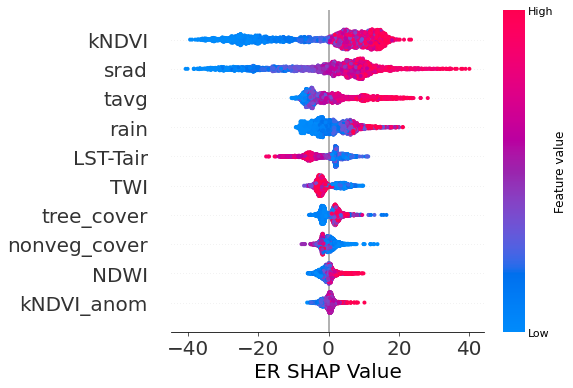

In [42]:
fig, ax = plt.subplots(1,1, figsize=(5,11))
shap.summary_plot(shap_values, max_display=10, show=False, feature_names=feature_importance['col_name'])
plt.gcf().axes[-1].set_aspect('auto')
plt.gcf().axes[-1].set_box_aspect(15) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.set_xlabel(model_var+' SHAP Value', fontsize=20)
plt.tight_layout()
fig.savefig("/g/data/os22/chad_tmp/NEE_modelling/results/cross_validation/feature_importance_"+model_var+"_lgbm_"+suffix+".png", bbox_inches='tight')

### Dependency scatter plots (including main interaction effect)

showing the effect a single features have on the predictions made by the model

### First plots show the dependence for the top 4 predictors

In [43]:
font=24

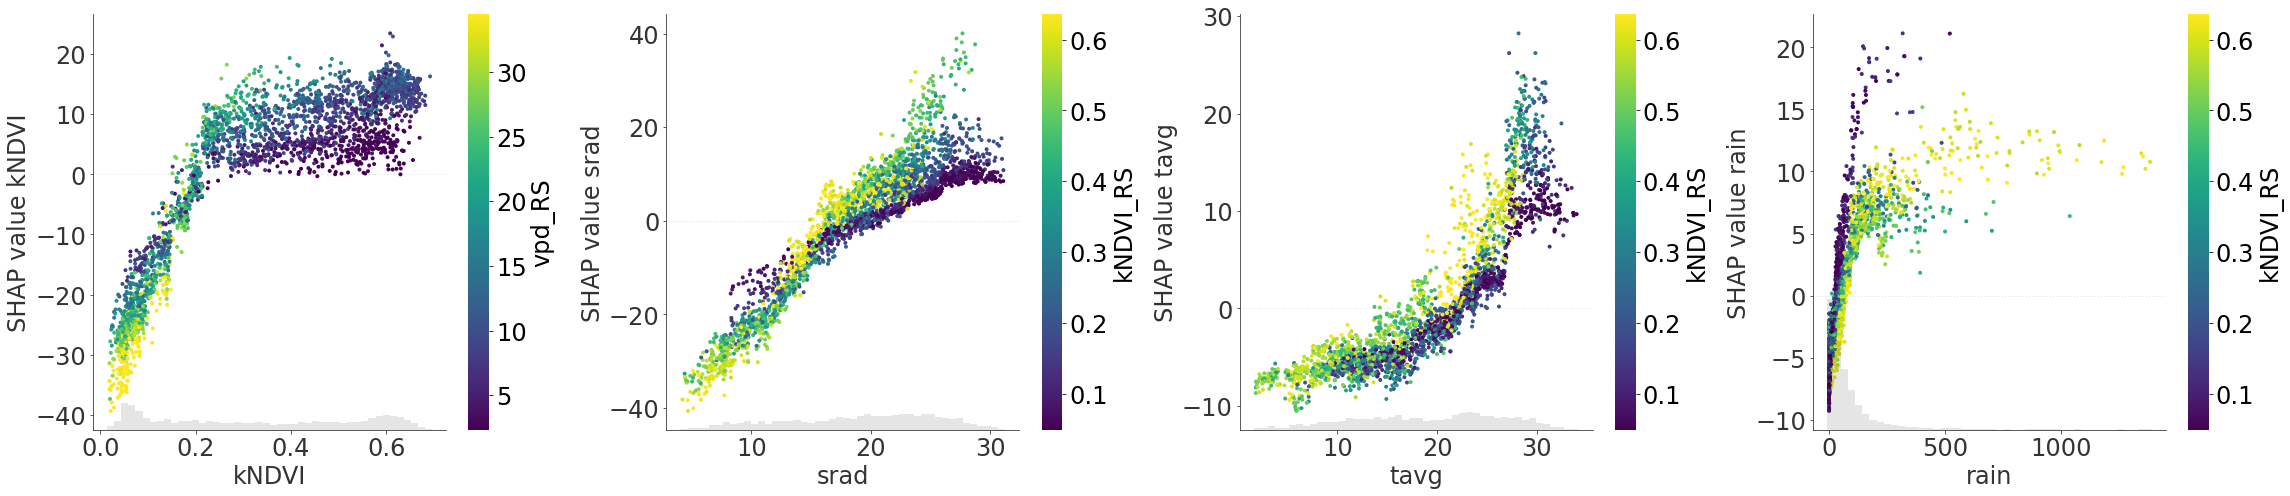

In [44]:
fig, axs = plt.subplots(1,4, figsize=(32,7))

for ax, feature in zip(axs.ravel(), list(feature_importance['col_name'])[0:4]):
    shap.plots.scatter(shap_values[:,feature+'_RS'], ax=ax, show=False, color=shap_values, cmap='viridis')
    ax.set_ylabel('SHAP value '+ feature,  fontsize=font)
    ax.set_xlabel(feature, fontsize=font)
    ax.tick_params(axis='x', labelsize=font)
    ax.tick_params(axis='y', labelsize=font)
    plt.gcf().axes[-2].set_aspect('auto')
    plt.gcf().axes[-2].set_box_aspect(20)
    plt.gcf().axes[-2].yaxis.label.set_fontsize(font)
    plt.gcf().axes[-2].tick_params(axis='y', labelsize=font)
plt.tight_layout()
fig.savefig("/g/data/os22/chad_tmp/NEE_modelling/results/cross_validation/interaction_scatterplots_"+model_var+"_lgbm_"+suffix+".png", bbox_inches='tight')

### Second plots show the dependence for the four main climate predictors (with kNDVI interaction)

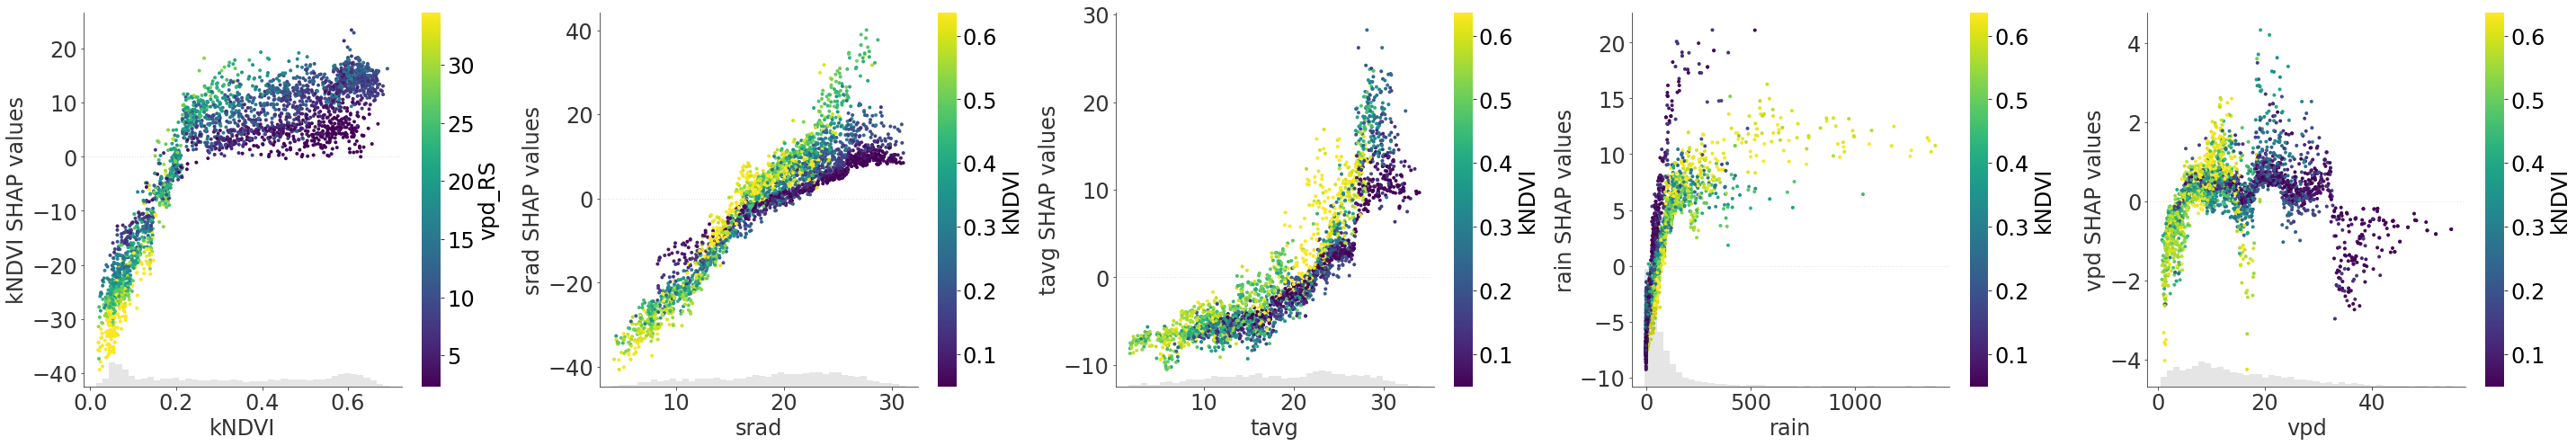

In [45]:
fig, axs = plt.subplots(1,5, figsize=(40,7))

for ax, feature in zip(axs.ravel(), ['kNDVI', 'srad', 'tavg', 'rain', 'vpd']):
    if feature =='kNDVI':
        shap.plots.scatter(shap_values[:,feature+'_RS'], ax=ax, show=False, color=shap_values, cmap='viridis')
    else:
        shap.plots.scatter(shap_values[:,feature+'_RS'], ax=ax, show=False, color=shap_values[:,'kNDVI_RS'], cmap='viridis')
        plt.gcf().axes[-2].set_ylabel('kNDVI')
    ax.set_ylabel(feature+' SHAP values',  fontsize=font)
    ax.set_xlabel(feature, fontsize=font)
    ax.tick_params(axis='x', labelsize=font)
    ax.tick_params(axis='y', labelsize=font)
    plt.gcf().axes[-2].set_aspect('auto')
    plt.gcf().axes[-2].set_box_aspect(20)
    plt.gcf().axes[-2].yaxis.label.set_fontsize(font)
    plt.gcf().axes[-2].tick_params(axis='y', labelsize=font)
plt.tight_layout()
fig.savefig("/g/data/os22/chad_tmp/NEE_modelling/results/cross_validation/interaction_scatterplots_climatevars_"+model_var+"_lgbm_"+suffix+".png", bbox_inches='tight')

## Predict the sites time-series to compare

In [ ]:
# for site in sites:
#     print(site)
#     df = ts.loc[ts['site'] == site]
#     df = df.dropna()
#     if model_var == 'ET':
#         df_y=df[model_var+'_EC']
#     else:
#         df_y=df[model_var+'_SOLO_EC'] # seperate out the variable we're modelling
   
#     df_x = df[variables]
#     df_x = df_x.drop('site', axis=1)
    
#     x = df_x.reset_index(drop=True)#.to_numpy()
#     y = df_y.reset_index(drop=True)#.to_numpy()

#     y_pred = model.predict(x)

#     rmse = float(format(np.sqrt(mean_squared_error(y, y_pred)), '.3f'))
#     r2_ = r2_score(y, y_pred)
    
#     #Compare time-series in a plot
#     df_y_true = df[[model_var+'_SOLO_EC']]
#     df_y_true['pred_'+model_var] = y_pred 
    
#     sb.set_style("darkgrid")
#     fig,ax = plt.subplots(1,1, figsize=(12,5))
#     sb.lineplot(x='time', y=model_var+'_SOLO_EC', data=df_y_true, color="green", linewidth=1, ax=ax)
#     sb.lineplot(x='time', y='pred_'+model_var, data=df_y_true, color="blue", linewidth=1, ax=ax)

#     ax.text(.015, .95, 'r = {:.3f}'.format(r2_),
#             transform=ax.transAxes)
#     ax.text(.015, .9, 'mae = {:.3g}'.format(ac),
#             transform=ax.transAxes)

#     ax.set_ylabel(model_var)
#     ax.set_xlabel(None)
#     ax.set_title(site+': '+model_var + ' Cross Validation Results')
#     plt.legend(labels=["True","Prediction"], loc='lower left')
#     plt.tight_layout()
#     fig.savefig("/g/data/os22/chad_tmp/NEE_modelling/results/timeseries_predict/"+site+"_"+model_var+"_LGBM.png")
#     plt.close()